In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from nltk.tokenize import word_tokenize
from nltk.tokenize import sent_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
import string

import pickle


import re

import pattern
from pattern.en import lemma, lexeme

import contractions
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer 
import nltk
from collections import defaultdict
import time

import gensim

#### Preprocessing

In [4]:
# functions for text preprocessing
stop_words = set(stopwords.words("english"))
def remove_Stopwords(text): 
    #stop_words = set(stopwords.words("english"))
    words = word_tokenize(text.lower())
    sentence = [w for w in words if not w in stop_words]
    return " ".join(sentence)

def lemmatize_text(text): 
    wordlist=[]
    lemmatizer = WordNetLemmatizer()
    sentences = sent_tokenize(text)
    for sentence in sentences: 
        words=word_tokenize(sentence)
        for word in words: 
            wordlist.append(lemmatizer.lemmatize(word))
    return " ".join(wordlist)

def clean_text(text): 
    # remove punctuation
    delete_dict = {sp_character:"" for sp_character in string.punctuation}
    delete_dict[" "] = " "
    table=str.maketrans(delete_dict)
    text1=text.translate(table)
    
    textArr = text1.split()
    text2= " ".join([w for w in textArr])
    
    # lower case + remove \n and ' that has not been removed in the previous function
    return text2.lower().replace("'", "").replace("\n", "")

def get_wordnet_pos(word):
    """Map POS tag to first character lemmatize() accepts"""
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}

    return tag_dict.get(tag, wordnet.NOUN)


#def lemmatizer_func(text): 
#    lemmatizer = WordNetLemmatizer()
#    aux = [lemmatizer.lemmatize(w, get_wordnet_pos(w)) for w in nltk.word_tokenize(text)]
#    return " ".join([w for w in aux])

lemmatizer = WordNetLemmatizer()


def lemmatizer_func(text): 
    result=[]
    tokens = nltk.word_tokenize(text)
    pos_tags = nltk.pos_tag(tokens)
    text_pos = list(zip(tokens, [get_wordnet_pos(tag[1]) for tag in pos_tags]))
    lemmatized = [lemmatizer.lemmatize(text_pos[i][0], text_pos[i][1]) for i in range(0,len(text_pos))]
    [result.append(token) for token in lemmatized]
    return " ".join(result)


In [5]:

def full_preprocess(df): 
    prep= df.copy()
    prep['text_processed'] = prep['clean_text'].apply(lambda x:re.sub(r'http\S+', '', x))# remove urls
    prep['text_processed'] = prep['text_processed'].apply(lambda x:re.sub(r'www\S+', '', x))# remove urls
    prep['text_processed'] = prep['text_processed'].apply(lambda x: re.sub('\S*@\S*\s?', '',x)) # remove emails
    prep["text_processed"] = prep["text_processed"].apply(lambda x: contractions.fix(x)) # expand contractions
    prep["text_processed"] = prep["text_processed"].apply(clean_text) # remove punctuation, lower case, ...
    prep['text_processed'] = prep['text_processed'].apply(lambda x: re.sub(r'\w*\d\w*','',x))# remove words that contains a digit (eg: name57)
    prep["text_processed"]= prep["text_processed"].apply(remove_Stopwords) #remove stopwords
    prep["text_processed"]=prep["text_processed"].apply(lambda x: re.sub(r'[0-9]+','',x))# remove digits
    prep["text_processed"]= prep["text_processed"].apply(lambda x: " ".join([lemma(wd) for wd in x.split()])) #lemmatization
    
    return prep


In [6]:
news = pd.read_csv(r"D:\TFG\tfg_git\data\news\news3_v2.csv")
mails = pd.read_csv(r"D:\TFG\tfg_git\data\mails\corpus_v2.0.csv")

In [8]:
# news prep
start=time.time()
news_prep = full_preprocess(news)
end=time.time()
print("Time ellapsed: ", end-start)


Time ellapsed:  80.50537848472595


In [9]:
# mails prep
start=time.time()
mails_prep = full_preprocess(mails)
end=time.time()
print("Time ellapsed: ", end-start)


Time ellapsed:  0.7040140628814697


In [30]:
# join both datasets
dff = pd.concat([news_prep, mails_prep], ignore_index=True)
dff["id"] = dff.index.values.tolist()

In [31]:
dff.columns

Index(['index', 'url', 'published', 'crawled', 'author', 'topic', 'uuid',
       'title', 'text', 'site', 'domainRank', 'timeDiff', 'authorInText',
       'twAccountMentions', 'clean_text', 'personCounter', 'published_short',
       'Biden', 'Sanders', 'Warren', 'Bloomberg', 'Buttigieg', 'tipo',
       'text_processed', 'from_name', 'from_address', 'subject', 'body_text',
       'name', 'office_sought', 'party_affiliation', 'office_level',
       'district_type', 'final_website', 'crawl_date', 'source', 'state',
       'type', 'subtype', 'date', 'hour', 'day', 'uid_email', 'uid_inbox',
       'incumbent', 'id'],
      dtype='object')

In [32]:
dff[["Biden", "Sanders", "Warren", "Bloomberg", "Buttigieg"]]

,Biden,Sanders,Warren,Bloomberg,Buttigieg
0,0,1,0,1,1
1,1,1,0,1,1
2,0,1,1,1,1
3,1,1,1,1,1
4,0,1,1,1,1
...,...,...,...,...,...
27164,0,0,0,0,1
27165,0,0,0,0,1
27166,0,0,0,0,1
27167,0,0,0,0,1


In [33]:
dff = dff[["text_processed", "tipo", "id", "Biden", "Sanders", "Warren", "Bloomberg", "Buttigieg"]]

In [34]:
# saving processed data
dff.to_csv(r"D:\TFG\tfg_git\data\clean_text\data_clean_text.csv", index=False)

### TF-IDF implementation

In [35]:
from sklearn.feature_extraction.text import TfidfVectorizer
x = dff[dff["tipo"]=="News"].text_processed.tolist()

In [36]:
dff.columns

Index(['text_processed', 'tipo', 'id', 'Biden', 'Sanders', 'Warren',
       'Bloomberg', 'Buttigieg'],
      dtype='object')

In [38]:
x_candidates = dff[dff["tipo"]=="News"][["text_processed", "id",'Biden', 'Sanders', 'Warren',
       'Bloomberg', 'Buttigieg']]
x_candidates.to_csv(r"D:\TFG\tfg_git\data\tf_idf\news_processed_tfidf_candidatesID.csv", index=False)

In [39]:
# max_df te permite especificar la frecuencia máxima que una palabra puede tener para ser incluida en el vocabulario. 
# descartamos palabras que aparecen en mas del 97.5% y en menos del 2.5% de los documentos

vectorizer = TfidfVectorizer(max_df=0.975, min_df=0.025)
X = vectorizer.fit_transform(x)


In [40]:
tfidf_df = pd.DataFrame(X.toarray(), columns=vectorizer.get_feature_names_out())
tfidf_df

,abandon,abc,ability,able,abortion,abroad,absolutely,abuse,abusive,accelerate,...,yield,york,yorker,you,young,younger,youth,youtube,zero,zone
0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.161848,0.000000
1,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.023570,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000
2,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.032696,0.0,0.037255,0.000000,0.0,0.0,0.0,0.000000,0.000000
3,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.026708,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000
4,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.029006,0.0,0.033051,0.000000,0.0,0.0,0.0,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26496,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.048165,0.000000,0.0,0.0,0.0,0.000000,0.059712
26497,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.047607,0.000000,0.0,0.0,0.0,0.000000,0.000000
26498,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000
26499,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.019335,0.000000,0.0,0.0,0.0,0.000000,0.000000


In [41]:
tfidf_df.to_csv(r"D:\TFG\tfg_git\data\tf_idf\news_processed_tfidf.csv", index=False)

In [43]:
# lets transform the mails dataset
dff["tipo"].value_counts()

News     26501
Mails      668
Name: tipo, dtype: int64

In [44]:
x_mails = dff[dff["tipo"]=="Mails"].text_processed.tolist()

X_mails = vectorizer.transform(x_mails)

In [45]:
tfidf_mails = pd.DataFrame(X_mails.toarray(), columns=vectorizer.get_feature_names_out())
tfidf_mails

,abandon,abc,ability,able,abortion,abroad,absolutely,abuse,abusive,accelerate,...,yield,york,yorker,you,young,younger,youth,youtube,zero,zone
0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.000000,0.000000,0.0,0.0,0.056201,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
663,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
664,0.0,0.0,0.066054,0.055277,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
665,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
666,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [46]:
tfidf_mails.to_csv(r"D:\TFG\tfg_git\data\tf_idf\mails_processed_tfidf.csv", index=False)

In [47]:
x_candidates = dff[dff["tipo"]=="Mails"][["text_processed", "id",'Biden', 'Sanders', 'Warren',
       'Bloomberg', 'Buttigieg']]
x_candidates.to_csv(r"D:\TFG\tfg_git\data\tf_idf\mails_processed_tfidf_candidatesID.csv", index=False)

## LDA implementation

In [132]:
import pandas as pd
import gensim
from gensim.models import CoherenceModel
from gensim.corpora import Dictionary
import scipy.sparse as sparse
from gensim import matutils
import scipy
from tqdm import tqdm
import gensim.corpora as corpora

In [188]:
news_tfidf = tfidf_df
corpus_news = matutils.Sparse2Corpus(scipy.sparse.csc_matrix(news_tfidf.transpose()))

mails_tfidf = tfidf_mails
corpus_mails = matutils.Sparse2Corpus(scipy.sparse.csc_matrix(mails_tfidf.transpose()))

In [55]:
id2word = dict((v, k) for k, v in vectorizer.vocabulary_.items())

In [57]:
lda = gensim.models.ldamodel.LdaModel(corpus=corpus_news, id2word=id2word, num_topics=2, passes=10)


In [58]:
lda.print_topics()

[(0,
  '0.008*"sander" + 0.006*"trump" + 0.006*"say" + 0.005*"democratic" + 0.005*"democrat" + 0.005*"vote" + 0.004*"campaign" + 0.004*"bloomberg" + 0.004*"president" + 0.004*"candidate"'),
 (1,
  '0.007*"trump" + 0.007*"say" + 0.004*"new" + 0.004*"you" + 0.004*"state" + 0.004*"president" + 0.003*"coronaviru" + 0.003*"year" + 0.003*"february" + 0.003*"government"')]

##### Hyperparameter Tuning

In [99]:
news_candidates = pd.read_csv(r"D:\TFG\tfg_git\data\tf_idf\news_processed_tfidf_candidatesID.csv")

In [154]:
texts = [[id2word[word_id] for (word_id, tfidf_score) in doc] for doc in corpus_news]
id2word = corpora.Dictionary(texts)

In [159]:
id2word = corpora.Dictionary.from_corpus(corpus_news, id2word=None)


In [ ]:
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus_news,
                                        id2word=id2word,
                                        num_topics=2,
                                        random_state=42,
                                        update_every=1,
                                        passes=10,
                                        alpha='auto',
                                        per_word_topics=True)

coherence_model_cv = CoherenceModel(model=lda_model, texts=texts,corpus=corpus_news, dictionary=id2word, coherence='c_v')
coherence_model.get_coherence()


AttributeError: 'dict' object has no attribute 'id2token'

In [184]:
coherence_model_cv = CoherenceModel(model=lda_model, texts=texts,corpus=corpus_news, dictionary=id2word, coherence='c_v')
coherence_model.get_coherence()

AttributeError: 'dict' object has no attribute 'id2token'

In [225]:
from tqdm import tqdm
# Definir una lista de posibles números de tópicos
min_topics = 2
max_topics = 40
step_size = 6
num_topics_list = range(min_topics, max_topics, step_size)

# crear una lista de modelos LDA y medidas de coherencia C_V para cada número de tópicos
lda_models = []
cv_scores = []
perplexity_scores = []
umass_scores = []

for num_topics in tqdm(num_topics_list):
    lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus_news,
                                            id2word=id2word,
                                            num_topics=num_topics,
                                            random_state=42,
                                            update_every=1,
                                            passes=10,
                                            alpha='auto',
                                            per_word_topics=True)
    lda_models.append(lda_model)
    #coherence_model_cv = CoherenceModel(model=lda_model, texts=texts, dictionary=id2word, coherence='c_v')
    coherence_model_umass = CoherenceModel(model=lda_model, corpus=corpus_news, coherence='u_mass')
    
    #cv_score = coherence_model_cv.get_coherence()
    umass_score = coherence_model_umass.get_coherence()
    #cv_scores.append(cv_score)
    umass_scores.append(umass_score)
    perplexity_scores.append(lda_model.log_perplexity(corpus_news))

    
# encontrar el número de tópicos con la mejor medida de coherencia C_V
#best_num_topics_cv = num_topics_list[cv_scores.index(max(cv_scores))]
best_num_topics_umass = num_topics_list[umass_scores.index(min(umass_scores))]
best_num_topics_perplexity = num_topics_list[perplexity_scores.index(min(perplexity_scores))]





100%|███████████████████████████████████████████████████████████████████████████████████| 7/7 [28:13<00:00, 241.87s/it]


In [226]:
# imprimir el número de tópicos con la mejor medida de coherencia C_V
#print(f"El número de tópicos con la mejor medida de coherencia C_V es: {best_num_topics_cv}")
print(f"El número de tópicos con la mejor medida de coherencia UMass es: {best_num_topics_umass}")
print(f"El número de tópicos con la mejor perplexity score: {best_num_topics_perplexity}")

El número de tópicos con la mejor medida de coherencia UMass es: 38
El número de tópicos con la mejor perplexity score: 32


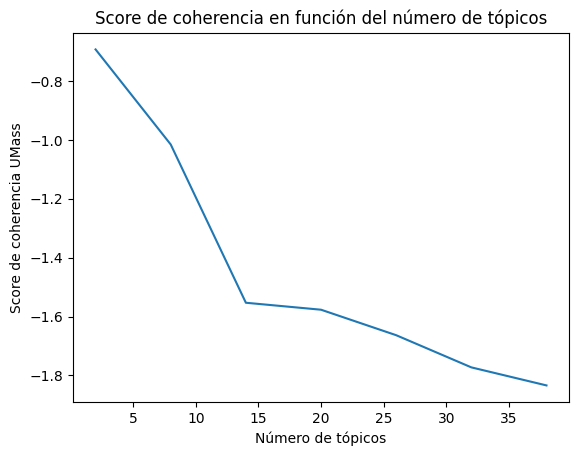

In [227]:
# plot coherencias 
# coherence scores visualization

coherence_scores = umass_scores
num_topics = num_topics_list

plt.plot(num_topics, coherence_scores)
plt.xlabel("Número de tópicos")
plt.ylabel("Score de coherencia UMass")
plt.title("Score de coherencia en función del número de tópicos")
plt.show()

# numero optimo de topicos es 

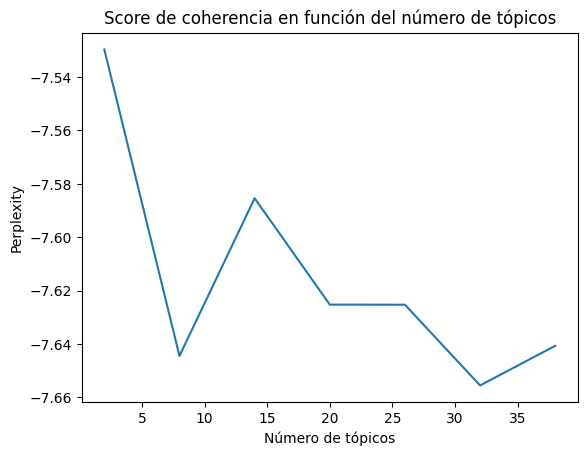

In [228]:
# plot coherencias 
# coherence scores visualization

coherence_scores = perplexity_scores
num_topics = num_topics_list

plt.plot(num_topics, coherence_scores)
plt.xlabel("Número de tópicos")
plt.ylabel("Perplexity")
plt.title("Score de coherencia en función del número de tópicos")
plt.show()

# numero optimo de topicos es 

#### numero optimo de topicos: 

In [232]:
#ajustamos el modelo con el número optimo de topicos
optim_number_topics = 10
id2word = dict((v, k) for k, v in vectorizer.vocabulary_.items())
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus_news, id2word=id2word, num_topics=optim_number_topics, passes=10)



In [233]:
lda_model.print_topics()

[(0,
  '0.009*"say" + 0.008*"associate" + 0.008*"new" + 0.008*"state" + 0.007*"press" + 0.007*"immigration" + 0.007*"february" + 0.007*"federal" + 0.007*"trump" + 0.006*"york"'),
 (1,
  '0.056*"raw" + 0.030*"story" + 0.025*"reader" + 0.024*"contribution" + 0.022*"click" + 0.019*"invest" + 0.016*"advertisement" + 0.015*"johnston" + 0.015*"evasion" + 0.015*"journalism"'),
 (2,
  '0.007*"budget" + 0.007*"trump" + 0.006*"tax" + 0.006*"say" + 0.005*"year" + 0.005*"would" + 0.005*"billion" + 0.004*"cut" + 0.004*"company" + 0.004*"amazon"'),
 (3,
  '0.132*"india" + 0.057*"delhi" + 0.053*"modi" + 0.046*"indian" + 0.034*"visit" + 0.025*"new" + 0.023*"minister" + 0.021*"app" + 0.020*"melania" + 0.018*"time"'),
 (4,
  '0.016*"sander" + 0.013*"bloomberg" + 0.011*"biden" + 0.008*"democratic" + 0.008*"buttigieg" + 0.008*"say" + 0.008*"candidate" + 0.008*"campaign" + 0.006*"debate" + 0.006*"warren"'),
 (5,
  '0.008*"trump" + 0.005*"say" + 0.005*"president" + 0.003*"people" + 0.003*"one" + 0.003*"woul

In [234]:
topics = lda_model.show_topics(formatted=False)

for topic in topics:
    print("Topic #{}:".format(topic[0]))
    print(" ".join([word[0] for word in topic[1]]))

Topic #0:
say associate new state press immigration february federal trump york
Topic #1:
raw story reader contribution click invest advertisement johnston evasion journalism
Topic #2:
budget trump tax say year would billion cut company amazon
Topic #3:
india delhi modi indian visit new minister app melania time
Topic #4:
sander bloomberg biden democratic buttigieg say candidate campaign debate warren
Topic #5:
trump say president people one would impeachment get like go
Topic #6:
castro cuba fidel sander regime communist authoritarian florida praise dictator
Topic #7:
coronaviru say china viru iran you trade trump outbreak market
Topic #8:
voter republican vote democrat say candidate district election democratic poll
Topic #9:
dr afraid discrimination fewer boom pundit incumbent famou factory stream


In [220]:
"""import pyLDAvis.gensim_models
import gensim

# Convertir el corpus y el diccionario en un formato que PyLDAvis pueda entender
vis_data = pyLDAvis.gensim_models.prepare(lda_model,corpus_news, id2word)

# Visualizar los tópicos
pyLDAvis.display(vis_data)"""

ModuleNotFoundError: No module named 'pyLDAvis'

C:\Users\User\AppData\Local\Temp\ipykernel_240\1614205169.py:26: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(df.loc[df.topic_id==i, 'word'], rotation=30, horizontalalignment= 'right')


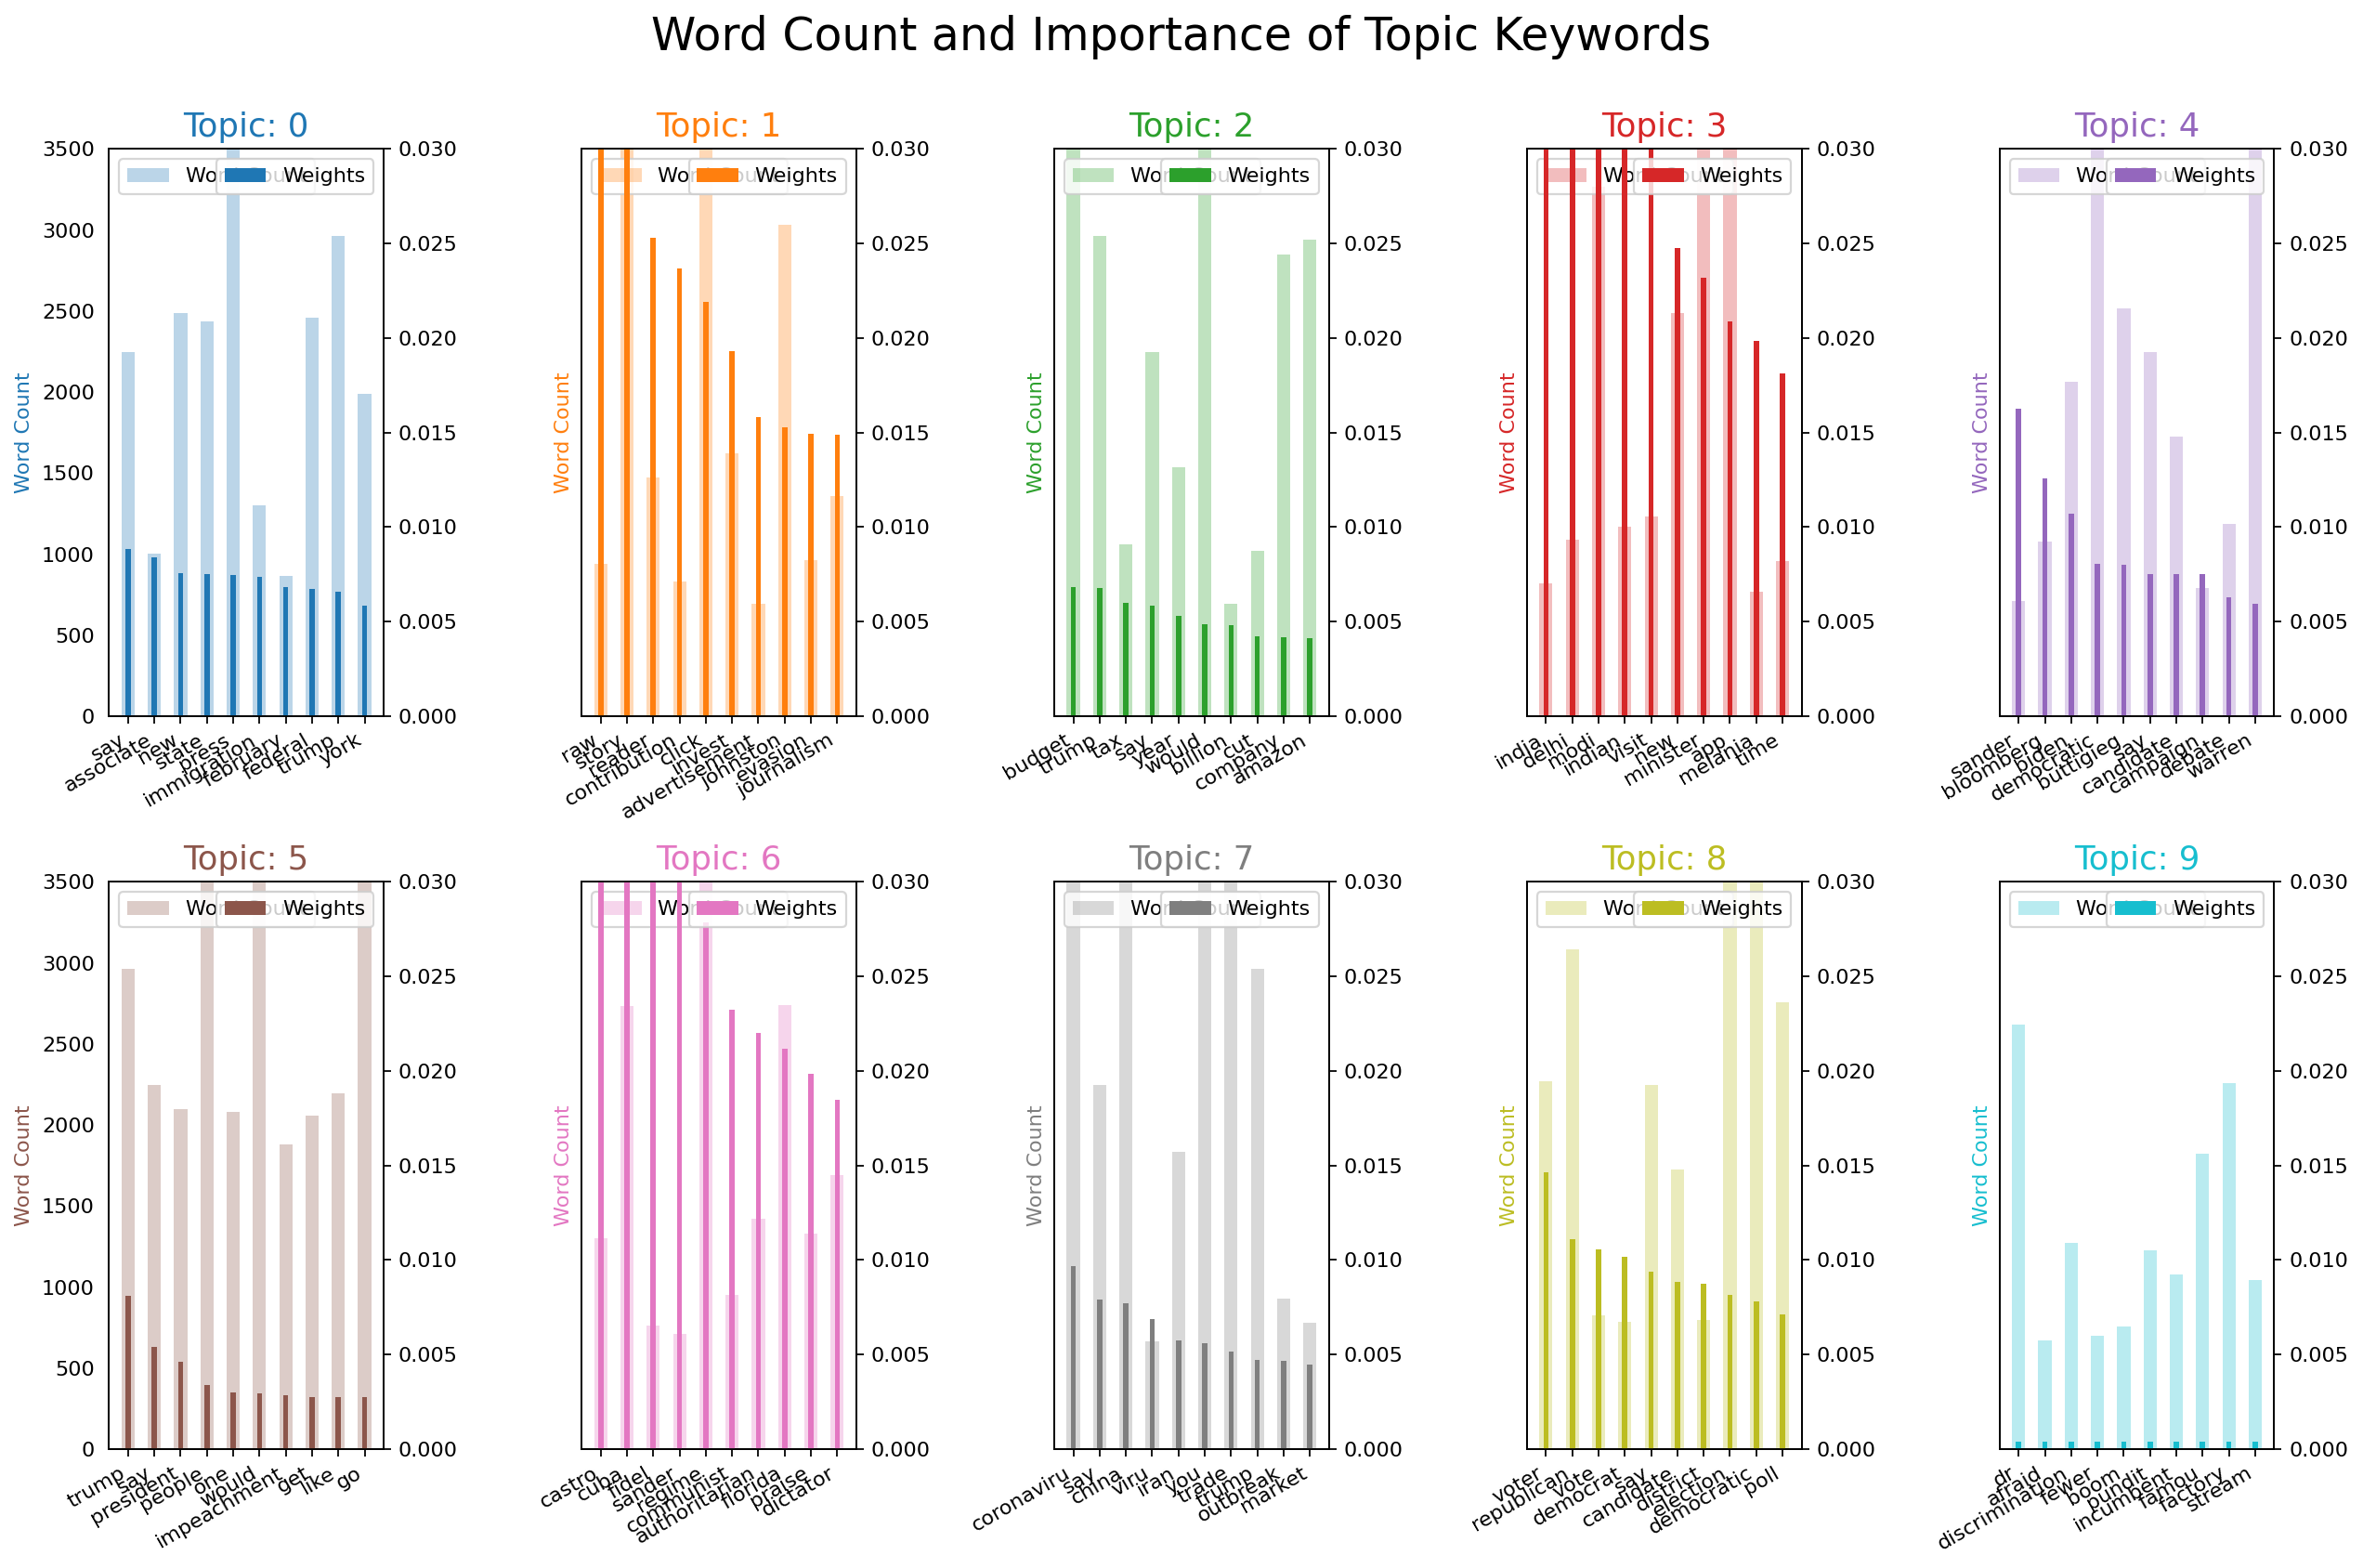

In [251]:
from collections import Counter
import matplotlib.colors as mcolors

topics = lda_model.show_topics(formatted=False)
data_flat = [w for w_list in texts for w in w_list]
counter = Counter(data_flat)

out = []
for i, topic in topics:
    for word, weight in topic:
        out.append([word, i , weight, counter[word]])

df = pd.DataFrame(out, columns=['word', 'topic_id', 'importance', 'word_count'])        

# Plot Word Count and Weights of Topic Keywords
fig, axes = plt.subplots(2, 5, figsize=(16,10), sharey=True, dpi=160)
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]
for i, ax in enumerate(axes.flatten()):
    ax.bar(x='word', height="word_count", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.5, alpha=0.3, label='Word Count')
    ax_twin = ax.twinx()
    ax_twin.bar(x='word', height="importance", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.2, label='Weights')
    ax.set_ylabel('Word Count', color=cols[i])
    ax_twin.set_ylim(0, 0.030); ax.set_ylim(0, 3500)
    ax.set_title('Topic: ' + str(i), color=cols[i], fontsize=16)
    ax.tick_params(axis='y', left=False)
    ax.set_xticklabels(df.loc[df.topic_id==i, 'word'], rotation=30, horizontalalignment= 'right')
    ax.legend(loc='upper left'); ax_twin.legend(loc='upper right')

fig.tight_layout(w_pad=2)    
fig.suptitle('Word Count and Importance of Topic Keywords', fontsize=22, y=1.05)    
plt.show()

In [ ]:
# wordclouds for each topic

In [ ]:
# number of coument per topic

#### Inferencia sobre corpus de mails

In [ ]:
mails_tfidf = tfidf_mails
corpus_mails = matutils.Sparse2Corpus(scipy.sparse.csc_matrix(mails_tfidf.transpose()))

In [ ]:
corpus_mails = [id2word.doc2bow(text) for text in corpus_mails]

In [ ]:
doc_lda = lda_model[corpus_mails]

In [ ]:
# Preprocesamiento del nuevo corpus de noticias
new_corpus = [...]  # lista de documentos preprocesados
new_texts = [doc.split() for doc in new_corpus]

# Creación del diccionario id-word
id2word_new = corpora.Dictionary(new_texts)

# Transformación del nuevo corpus de noticias en representación de tópicos
new_corpus_bow = [id2word_new.doc2bow(text) for text in new_texts]
new_corpus_topics = [model.get_document_topics(doc) for doc in new_corpus_bow]